## Analyze surface velocities of a video with velocimetry
This notebook shows how to use a camera configuration, and a video to estimate velocities at the surface. 
It also demonstrates the important impact of filtering of spurious or noisy velocities on the end result. We go through the following steps:

* Read a pre-defined camera configuration from file (we use the one prepared in notebook 1)
* Open a video, and provide the predefined camera configuration to it.
* Project frames to a planar projection
* Estimate surface velocities with Particle Image Velocimetry
* Filter raw velocities using several temporal and spatial filters
* Plot results in the camera objective


In [19]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar
from matplotlib import patches

### load our camera configuration
If you didn't do notebook 01, first go through that notebook to understand how a camera configuration is made.

Below, the camera configuration is loaded back into memory, and used to open a video file. We only need a couple of seconds video, so we use frame 0 until frame 125 only. We set `h_a` at zero, whioch is the same level as `h_ref` used in the camera configuration. This is because we use the same video. If we would use a video at a later moment in which the water level is 15 cm higher for instance, we would have to set `h_a=0.15` instead.

Because the video is taken with a smartphone (sorry, my hand is not super steady :-)) we also introduce the ``stabilize`` parameter. If you provide a list of pixel coordinates like ``[[x1, y1], [x2, y2], ...]`` that together form a polygon around the water surface, then any area outside of this polygon will be assumed to be stable. If any movements are detected in this area, these can then be assumed to be related to slight shaking of hands, and are used to correct video movements.

In [20]:
cam_config = pyorc.load_camera_config("BR.json")
video_file =  r"D:\STIV-based-Velocity-Estimation\Dataset_HW\bridge_main_1.MP4"
# set coordinates that encapsulate the water surface at minimum. Areas outside will be used for stabilization
stabilize = [
    [250 ,600],   # bottom left
    [500 , 400],   #  top left 
    [1400 , 400],    # top right
    [1500 , 600]     # bottom right
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=10,
    stabilize=stabilize,

)
video


Scanning video: 100%|██████████| 11/11 [00:00<00:00, 35.03it/s]
Deriving stabilization parameters from second frame onwards: 100%|██████████| 10/10 [00:00<00:00, 46.95it/s]



Filename: D:\STIV-based-Velocity-Estimation\Dataset_HW\bridge_main_1.MP4
FPS: 25.000000
start frame: 0
end frame: 10
Camera configuration: {
    "height": 1080,
    "width": 1920,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 43N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],MEMBER[\"World Geodetic System 1984 (G2296)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 43N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.017453

### Extract one frame with stabilization window
Below, let's have a look how the stabilization window encompasses the water surface. By including this, any area outside of the water is assumed (in the real world) to be stable and not moving, and any movements found there can then be corrected.

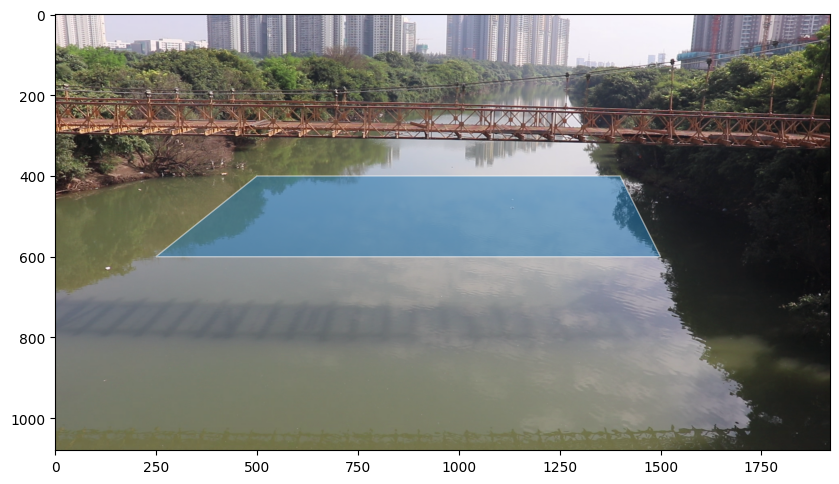

In [21]:
# some keyword arguments for fancy polygon plotting
patch_kwargs = {
    "alpha": 0.5,
    "zorder": 2,
    "edgecolor": "w",
    "label": "Area of interest",
}
f, ax = plt.subplots(1, 1, figsize=(10, 6))

frame = video.get_frame(0, method="rgb")
# plot frame on a notebook-style window
ax.imshow(frame)
# add the polygon to the axes
patch = patches.Polygon(
    stabilize,
    **patch_kwargs
)
p = ax.add_patch(patch)

### extracting gray scaled frames
You can see the video holds information about the video itself (filename, fps, and so on) but also the camera configuration supplied to it. We can now extract the frames. Without any arguments, the frames are automatically grayscaled and all frames are extracted.

In [22]:
da = video.get_frames()
da

<xarray.DataArray 'frames' (time: 11, y: 1080, x: 1920)> Size: 23MB
dask.array<from-value, shape=(11, 1080, 1920), dtype=uint8, chunksize=(11, 1080, 1920), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 88B 0.0 0.04 0.08 0.12 0.16 ... 0.28 0.32 0.36 0.4
  * y        (y) int32 4kB 1079 1078 1077 1076 1075 1074 1073 ... 6 5 4 3 2 1 0
  * x        (x) int32 8kB 0 1 2 3 4 5 6 ... 1913 1914 1915 1916 1917 1918 1919
    xp       (y, x) int32 8MB 0 1 2 3 4 5 6 ... 1914 1915 1916 1917 1918 1919
    yp       (y, x) int32 8MB 1079 1079 1079 1079 1079 1079 1079 ... 0 0 0 0 0 0
Attributes:
    camera_shape:   [1080, 1920]
    camera_config:  {\n    "height": 1080,\n    "width": 1920,\n    "crs": "P...
    h_a:            null
    chunksize:      20

The frames object is really a `xarray.DataFrame` object, with some additional functionalities under the method `.frames`. The beauty of our API is that it also uses lazy dask arrays to prevent very lengthy runs that then result in gibberish because of a small mistake along the way. We can see the shape and datatype of the end result, without actually computing everything, until we request a sample. Let's have a look at only the first frame with the plotting functionalities. If you want to use the default plot functionalities of `xarray` simply replace the line below by:
```
da[0].plot(cmap="gray")
```


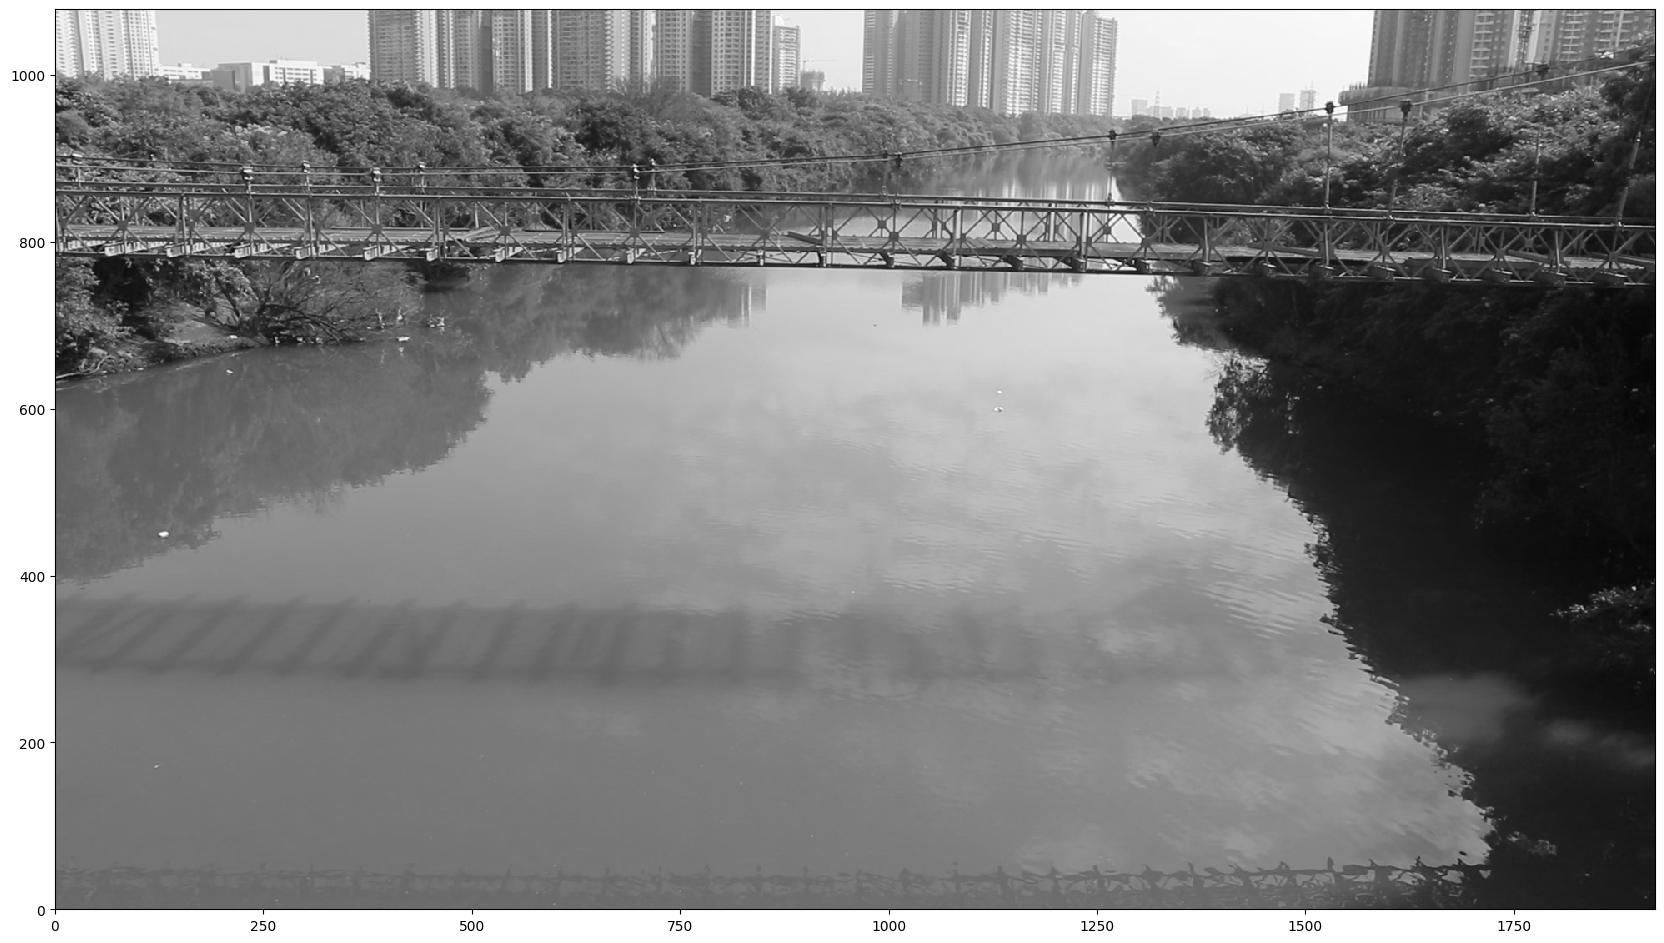

In [23]:
da[0].frames.plot(cmap="gray")


### normalize to add contrast
the `.frames` methods hold functionalities to improve the contrast of the image. A very good step is to remove the average of a larger set of frames from the frames itself, so that only strongly contrasting patterns from the background are left over. These are better traceable. We do this with the `.normalize` method. By default, 15 samples are used.

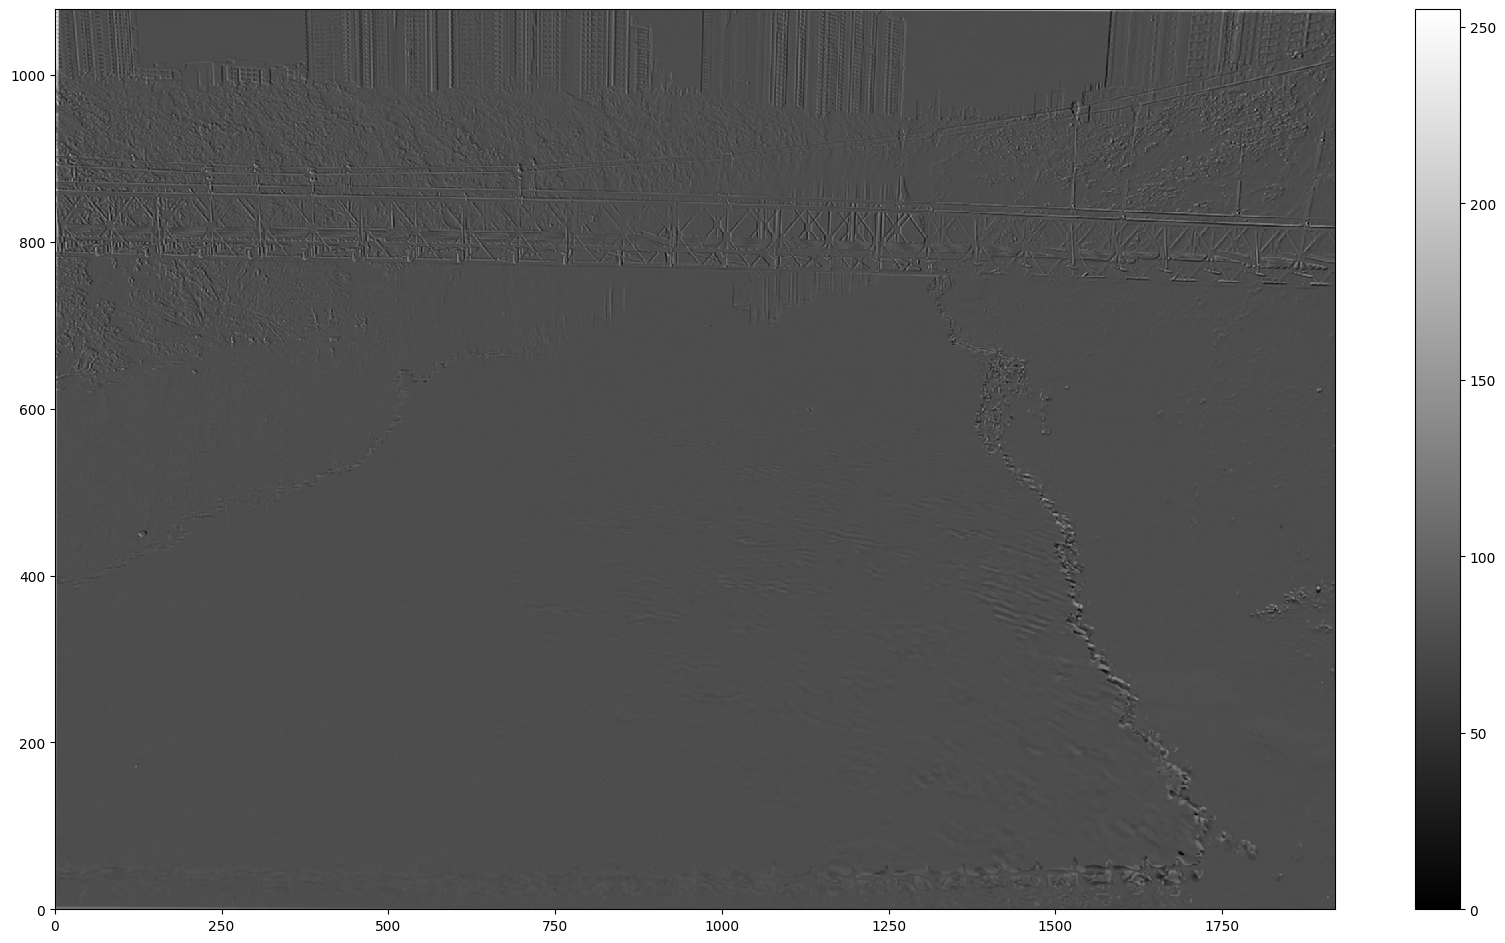

In [24]:
# da_norm = da.frames.time_diff(abs=False, thres=0.)
# da_norm = da_norm.frames.minmax(min=0.)
da_norm = da.frames.normalize()
p = da_norm[0].frames.plot(cmap="gray")
plt.colorbar(p)


A lot more contrast is visible now. We can now project the frames to an orthoprojected plane. The camera configuration, which is part of the `Video` object is used under the hood to do this. We use the new numpy-based projection method. The default is to use OpenCV methods, remove `method="numpy"` to try that.

In [ ]:
da_norm = da.frames.time_diff(abs=False, thres=0.)
da_norm = da_norm.frames.minmax(min=0.)
da_norm = da.frames.normalize()
p = da_norm[0].frames.plot(cmap="gray")
plt.colorbar(p)

MemoryError: Unable to allocate 1.90 GiB for an array with shape (84820725, 3) and data type float64

<Figure size 1600x900 with 0 Axes>

In [27]:
type(da_norm_proj)

matplotlib.collections.QuadMesh

You can see that the frames now also have x and y coordinates. These are in fact geographically aware, because we measured control points in real world coordinates and added a coordinate reference system to the `CameraConfig` object (see notebook 01). The `DataArray` therefore also contains coordinate grids for `lon` and `lat` for longitudes and latitudes. Hence we can also go through this entire pipeline with an RGB image and plot this in the real world by adding `mode="geographical"` to the plotting functionalities. The grid is rotated so that its orientation always can follow the stream (in the local projection shown above, left is upstream, right downstream). 
Plotting of an rgb frame geographically is done as follows:


AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

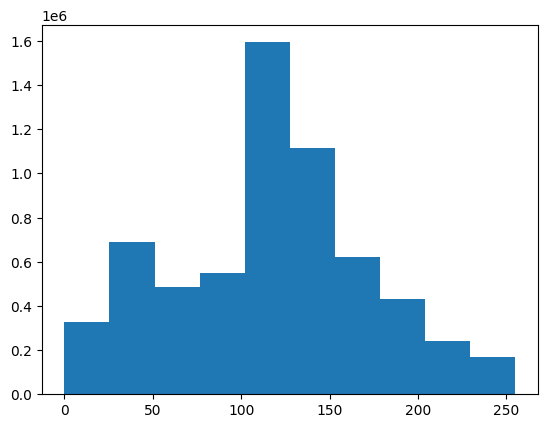

In [ ]:
# Extract RGB frames
da_rgb = video.get_frames(method="rgb")

# Pick only the first frame (instant)
da_rgb_proj = da_rgb.isel(time=0)

# Plot this frame directly (no reprojection)
p = da_rgb_proj.plot(cmap=None)  # cmap=None keeps RGB colors

# Add satellite background
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs

tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)

# Set approximate extent — since no reprojection, use simple pixel extent
ny, nx = da_rgb_proj.shape[-2:]


### Velocimetry estimates
Now that we have real-world projected frames, with contrast enhanced, let's do some velocimetry! For Particle Image Velocimetry, this is as simple as calling the `.get_piv` method on the frames. We then store the result in a nice NetCDF file. This file can be loaded back into memory with the `xarray` API without any additional fuss. We also use our new `numba` engine to compute PIV (version >= 0.7.0). This is faster than the original `openpiv` engine. If you want to try `openpiv` you can do this by changing the engine.
```python
piv = da_norm_proj.frames.get_piv(engine="openpiv")
```


In [ ]:
piv = da_norm_proj.frames.get_piv(engine="numba")
piv.to_netcdf("BR.nc")


AttributeError: 'QuadMesh' object has no attribute 'frames'

### Beautiful additions to your art gallery
Of course now we want to do some plotting and filtering, for that, please go to the next notebook

In [ ]:
type(da_norm_proj)


matplotlib.collections.QuadMesh